# CNN with TensorFlow

In [ ]:
# When using docker tensorflow/tensorflow:latest-juypter
!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org scikit-learn pandas

### Initialize the Kernel

In [ ]:
# mute Hardware optimzation messages
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '1'

In [2]:
# import required libraries
import tensorflow as tf
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))

## 1st part: classify MNIST using simple model
This MNIST dataset is a collection of 60000 handwritten digits and 10000 testing samples from the much larger NIST dataset. They have been size-normalized and centered in a fixed-size image for developer training.

The first model is a simple Multi-layer perceptron (a type of Neural Network) to perform classification tasks.

In [3]:
# Import the dataset from TensorFlow
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# Normalize the data to improve optimization performance
x_train, x_test = x_train /255.0, x_test /255.0

In [5]:
# Review the first few labels
print("categorical Labels")
print(y_train[0:5])

categorical Labels
[5 0 4 1 9]


In [6]:
# Encode the labels into a one-hot vector
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

# Review one-hot encoded labels
print("one hot encoded labels")
print(y_train[0:5])

one hot encoded labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


Check the size of the datasets

In [7]:
print("number of training examples:", x_train.shape[0])
print("number of test examples:", x_test.shape[0])

number of training examples: 60000
number of test examples: 10000


Shuffle the dataset to improve randomness on batching

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(50)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(50)

### Convert 2D images to 1D Vector

In [9]:
# use the tensorflow flatten class for the reduction
from tensorflow.keras.layers import Flatten
flatten = Flatten(dtype = 'float32')

print("original data shape")
print(x_train.shape)

print("flattened shape")
print(flatten(x_train).shape)

original data shape
(60000, 28, 28)
flattened shape
(60000, 784)


### Assigning bias and weights to null tensors

In [9]:
# Weight tensor
W = tf.Variable(tf.zeros([784, 10], tf.float32))

# Bias tensor
b = tf.Variable(tf.zeros([10], tf.float32))

### Adding Weights and Biases to Input

In [10]:
# Apply matrix multiplication between x (input) and W (weights) then add the bias
def forward(x):
  return tf.matmul(x,W) + b

### Softmax Regression
Applying activation function to classify images by generating respective probabilities

In [11]:
# an example of softmax calculation on an input vector
vector = [10, 0.2, 8]
softmax = tf.nn.softmax(vector)
print("softmax calculation")
print(softmax.numpy())
print("verifying normalization")
print(tf.reduce_sum(softmax))
print("finding vector with the largest value (label assignment)")
print("category", tf.argmax(softmax).numpy())

softmax calculation
[8.8075405e-01 4.8839214e-05 1.1919710e-01]
verifying normalization
tf.Tensor(1.0, shape=(), dtype=float32)
finding vector with the largest value (label assignment)
category 0


define the output layer

In [12]:
def activate(x):
  return tf.nn.softmax(forward(x))

Softmax is a generalized type of logistic function, so we can create a <code>model</code> function for convenience

In [17]:
  def model(x):
    x = flatten(x)
    return activate(x)

### Cost Function
This is a function used to minimize the difference between predicted and actual classifications. The cross entropy function is a popular cost function for use in categorical models

$$
CrossEntropy = \sum{y_{label}\cdot \log(y_{prediction})} $$

In [18]:
def cross_entropy(y_label, y_pred):
  return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))
  # addition of 1e-10 to prevent errors in zero calculations

# current loss function for unoptimized model
cross_entropy(y_train, model(x_train)).numpy()

np.float32(138155.12)

### Type of optimization: Gradient Descent

In [19]:
# The chosen optimizer Gradient Descent is well established
optimizer = tf.keras.optimizers.SGD(learning_rate=0.25)

The <code>GradientTape</code> is chosen as for the training step to automatically compute derivatives of the functions we have manually created and is applied using the <code>SGD</code> optimizer

In [20]:
def train_step(x, y):
  with tf.GradientTape() as tape:
    # compute the loss function
    current_loss = cross_entropy(y, model(x))
    # compute gradient of loss
    # (this is automatic! Even with specialized functions!)
    grads = tape.gradient(current_loss, [W,b])
    # apply SGD step to our Variables W and b
    optimizer.apply_gradients(zip(grads, [W,b]))
  return current_loss.numpy()

### Training batches
 _Batch Gradient Descent_ is good as it can generate a true gradient. However, due to its computational cost throughout training, its application in Neural Networks is commonly done in minibatches.

In [21]:
# zeroing out weights in case of repeated executions of model
# Weight tensor
W = tf.Variable(tf.zeros([784, 10], tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10], tf.float32))

loss_values = []
accuracies = []
epochs = 10

for i in range(epochs):
  j = 0
  # each batch has 50 examples
  for x_train_batch, y_train_batch in train_ds:
    j += 1
    current_loss = train_step(x_train_batch, y_train_batch)
    if j%500==0: # reporting intermittent batch statistics
      print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss))

  # collecting statistics at each epoch...loss function and accuracy
  current_loss = cross_entropy(y_train, model(x_train)).numpy()
  loss_values.append(current_loss)
  correct_prediction = tf.equal(tf.argmax(model(x_train), axis=1),
                                tf.argmax(y_train, axis=1))

  # accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
  accuracies.append(accuracy)
  print("end of epoch", str(i), "loss", str(current_loss), "accuracy", str(accuracy))

epoch  0 batch 500 loss: 308.78094
epoch  0 batch 1000 loss: 243.85347
end of epoch 0 loss 335063.8 accuracy 0.73728335
epoch  1 batch 500 loss: 270.43488
epoch  1 batch 1000 loss: 239.25098
end of epoch 1 loss 331978.1 accuracy 0.74156666
epoch  2 batch 500 loss: 290.95187
epoch  2 batch 1000 loss: 253.18973
end of epoch 2 loss 325348.25 accuracy 0.7507667
epoch  3 batch 500 loss: 292.71637
epoch  3 batch 1000 loss: 260.54138
end of epoch 3 loss 321318.7 accuracy 0.75453335
epoch  4 batch 500 loss: 289.2487
epoch  4 batch 1000 loss: 242.80728
end of epoch 4 loss 326882.06 accuracy 0.7500833
epoch  5 batch 500 loss: 280.16818
epoch  5 batch 1000 loss: 230.50214
end of epoch 5 loss 321615.75 accuracy 0.75516665
epoch  6 batch 500 loss: 277.45898
epoch  6 batch 1000 loss: 230.25873
end of epoch 6 loss 318383.2 accuracy 0.7596667
epoch  7 batch 500 loss: 296.34238
epoch  7 batch 1000 loss: 230.25853
end of epoch 7 loss 317834.22 accuracy 0.7604667
epoch  8 batch 500 loss: 294.98904
epoch 

### Test and Plots
Intermittent diagnostics (such as accuracy and loss over entire dataset) are commonly conducted using the testing dataset to identify the degree of fit. Overfitting is when the test metrics are distinctly less favourable than the train metrics.

In [22]:
correct_prediction_train = tf.equal(tf.argmax(model(x_train), axis=1),tf.argmax(y_train, axis=1))
accuracy_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32)).numpy()

correct_prediction_test = tf.equal(tf.argmax(model(x_test), axis=1), tf.argmax(y_test, axis=1))
accuracy_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32)).numpy()

print("training accuracy", accuracy_train)
print("test accuracy", accuracy_test)

training accuracy 0.7582833
test accuracy 0.7536


### Plotting the performance of optimizations at each epoch

Text(0, 0.5, 'loss')

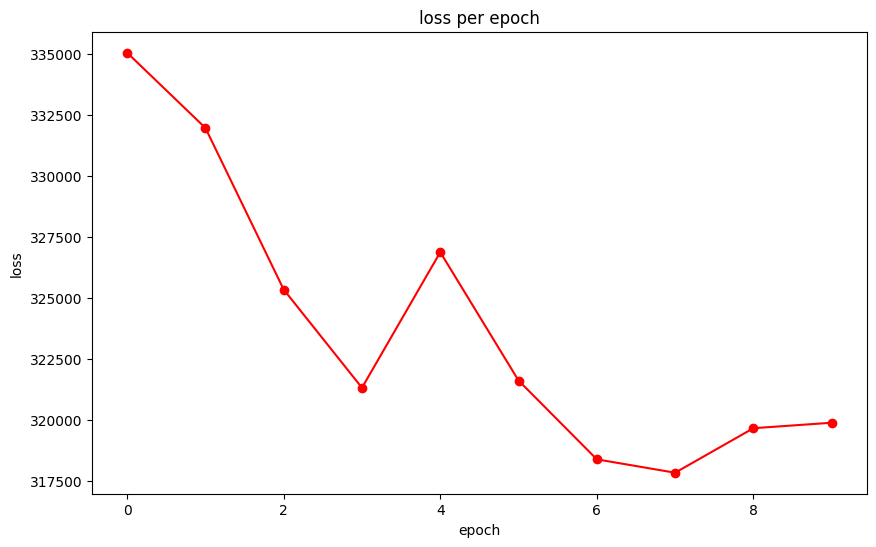

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
#print(loss_values)
plt.plot(loss_values, "-ro")
plt.title("loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

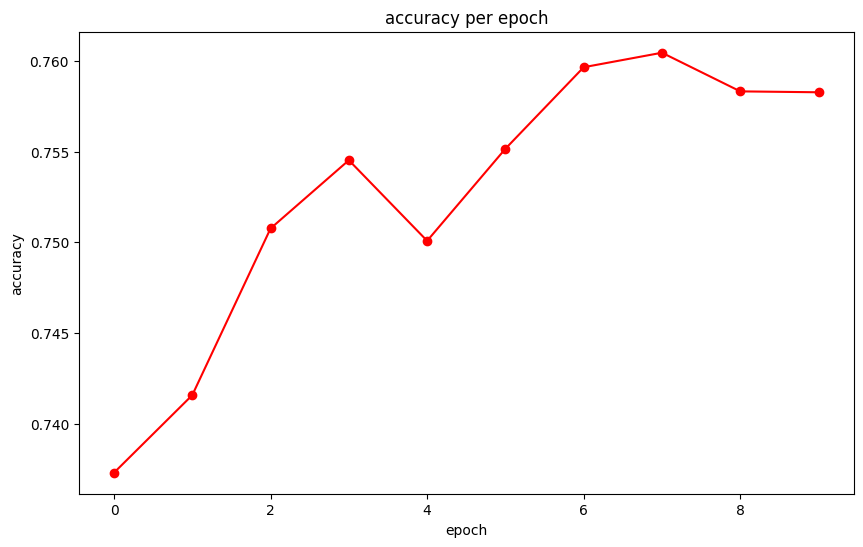

In [25]:
plt.plot(accuracies, "-ro")
plt.title("accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

### Improving the model
Several options include:
* Regularization of Neural Networks using DropConnect
* Multi-column Deep Neural Networks for Image Classification
* APAC: Augmented Pattern Classification with Neural Networks
* Simple Deep Neural Network with Dropout


<hr />

## 2nd part: Deep Learning applied on MNIST
This expands on the ANN model above to use Deep Neural Networks. Layers to add include:
* ReLU
* MaxPooling
* DropOut

### Initial Parameters

In [10]:
width = 28 # width of the image in pixels
height = 28 # height of the image in pixels
flat = width * height # number of pixels in one image
class_output = 10 # number of possible classifications for the problem

#### Convert images of the data set to tensors

In [11]:
x_image_train = tf.reshape(x_train, [-1,28,28,1])
x_image_train = tf.cast(x_image_train, "float32")

x_image_test = tf.reshape(x_test, [-1, 28,28,1])
x_image_test = tf.cast(x_image_test, "float32")

# creating new dataset with reshaped inputs
train_ds2 = tf.data.Dataset.from_tensor_slices((x_image_train, y_train)).batch(50)
test_ds2 = tf.data.Dataset.from_tensor_slices((x_image_test, y_test)).batch(50)

### Convolution Layer 1

#### Defining kernel weight and bias
* Size of the filter/kernel: 5x5
* Input channels: 1 (grayscale)
* Feature maps: 32

In this step, the filter/kernel tensor is of shape <code>[filter_height, filter_width, in_channels, out_channels]</code>

In [12]:
W_conv1 = tf.Variable(tf.random.truncated_normal([5,5,1,32], stddev=0.1, seed=0))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs

#### Convolve with weight tensor and add biases.

To create convolutional layer, we use <b>tf.nn.conv2d</b>. It computes a 2-D convolution given 4-D input and filter tensors.

Inputs:
- tensor of shape [batch, in_height, in_width, in_channels]. x of shape [batch_size,28 ,28, 1]
- a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]. W is of size [5, 5, 1, 32]
- stride which is  [1, 1, 1, 1]. The convolutional layer, slides the "kernel window" across the input tensor. As the input tensor has 4 dimensions:  [batch, height, width, channels], then the convolution operates on a 2D window on the height and width dimensions. __strides__ determines how much the window shifts by in each of the dimensions. As the first and last dimensions are related to batch and channels, we set the stride to 1. But for second and third dimension, we could set other values, e.g. [1, 2, 2, 1]
    
    
Process:
- Change the filter to a 2-D matrix with shape [5\*5\*1,32]
- Extracts image patches from the input tensor to form a *virtual* tensor of shape `[batch, 28, 28, 5*5*1]`.
- For each batch, right-multiplies the filter matrix and the image vector.

Output:
- A `Tensor` (a 2-D convolution) of size tf.Tensor 'add_7:0' shape=(?, 28, 28, 32)- Notice: the output of the first convolution layer is 32 [28x28] images. Here 32 is considered as volume/depth of the output image.


In [13]:
def convolve1(x):
  return tf.nn.conv2d(x, W_conv1, strides=[1,1,1,1], padding='SAME') + b_conv1

#### Apply the ReLU activation
This step goes through all outputs of the convolution step and replaces all negative values with 0.

In [14]:
def h_conv1(x):
  return tf.nn.relu(convolve1(x))

#### Apply Max Pooling
**Max Pooling** is a form of non-linear down-sampling. It partitions the input image into a set of rectangles and then find the maximum value for that region.

We will use:
* Function: `tf.nn.max_pool`
* Kernel size: 2x2
* Strides: 2

In [15]:
def conv1(x):
  return tf.nn.max_pool(h_conv1(x), ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

First Layer done!

### Convolutional Layer 2

#### Weights and Biases of kernels
For this layer, convolution is applied again with the following conditions:
* Filter/kernel: 5x5 (25 pixels)
* Input channels: 32 (from the 1st Conv layer --> 32 feature maps)
* 64 output feature maps

**Notice**: here, the input image is [14x14x32], and we have 64 filters of size [5x5x32], so the output would be 64 convolved image, or [14x14x64].

**Notice**: teh convolution result of applying a filter of size [5x5x32] on image of size [14x14x32] is an image of size [14x14x1], that is, the convolution is functioning on volume.

In [16]:
W_conv2 = tf.Variable(tf.random.truncated_normal([5,5,32,64], stddev=0.1, seed=1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) # need 64 biases for 64 outputs

#### Convolve image with weight tensor and add biases

In [17]:
def convolve2(x):
  return tf.nn.conv2d(conv1(x), W_conv2, strides=[1,1,1,1], padding='SAME') + b_conv2

#### Apply the ReLY activation function

In [18]:
def h_conv2(x):
  return tf.nn.relu(convolve2(x))

#### Apply the max pooling

In [19]:
def conv2(x):
  return tf.nn.max_pool(h_conv2(x), ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

Second Layer done
<hr />

### Fully Connected Layer
To use softmax to generate the final probabilities a fully connected layer will need to be implemented.

#### Flattening the Second Layer

In [20]:
def layer2_matrix(x):
  return tf.reshape(conv2(x), [-1,7*7*64])

#### Weights and Biases between layer 2 and 3
This is the multiplication of:
* Feature map from the last layer (7x7)
* number of feature maps (64)

In [21]:
W_fc1 = tf.Variable(tf.random.truncated_normal([7*7*64, 1024], stddev=0.1, seed=2))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))

#### Matrix Multiplication (applying weights and biases)

In [22]:
def fcl(x):
  return tf.matmul(layer2_matrix(x), W_fc1) + b_fc1

#### Apply the ReLU activation Function

In [23]:
def h_fc1(x):
  return tf.nn.relu(fcl(x))

Third layer completed
<hr />

### Dropout Layer, Option phase for reducing overfitting
In this layer, some features are "dropped" during processing to reduce the risk of overfitting

In [24]:
keep_prob = 0.5
def layer_drop(x):
  return tf.nn.dropout(h_fc1(x), keep_prob)

### Softmax (Readout) Layer

#### Weights and Biases
Here, CNN translates the high-level filtered images into votes using softmax. Details as follows:
* Input channels: 1024 (neurons from the 3rd layer)
* Output features: 10

In [25]:
W_fc2 = tf.Variable(tf.random.truncated_normal([1024, 10], stddev=0.1, seed=2)) # 1024 neurons
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) # 10 possibilities for digits 0 to 9

#### Matrix Multiplication (applying weights and biases)

In [26]:
def fc(x):
  return tf.matmul(layer_drop(x), W_fc2) + b_fc2

#### Apply the Softmax Activation Function

In [27]:
def y_CNN(x):
  return tf.nn.softmax(fc(x))

That's the CNN model
<hr />

## Defining the Functions and train the model

### Define the loss function
Cross Entropy can be used to measure the error at a softmax layer

In [28]:
# Toy sample of cross-entropy for a mini-batch of size 2
import numpy as np
layer4_test = [[0.9,0.1,0.1],[0.9,0.1,0.1]]
y_test=[[1.0,0.0,0.0],[1.0,0.0,0.0]]
np.mean(-np.sum(y_test * np.log(layer4_test), 1))

np.float64(0.10536051565782628)

In [29]:
def cross_entropy(y_label, y_pred):
  return -tf.reduce_sum(y_label * tf.math.log(y_pred +1.e-10))

#### Define the optimizer
To minimize the errors of the neural network, gradients of the loss should be computed by an optimizer: GradientDescent or Adagrad

In [30]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [31]:
# Using GradientTape to define the model
variables = [W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2]

def train_step(x, y):
  with tf.GradientTape() as tape:
    current_loss = cross_entropy(y, y_CNN(x))
    grads = tape.gradient(current_loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return current_loss.numpy()

### Define prediction
Counting the number of cases in each mini-batch that has been classified correctly

In [ ]:
correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1), tf.argmax(y_train, axis=1))

### Define accuracy

In [1]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float32'))

NameError: name 'tf' is not defined

### Run session, train

In [ ]:
loss_values = []
accuracies = []
epochs = 1 # controls the number of executions

for i in range(epochs):
  j = 0
  # each batch has 50 examples
  for x_train_batch, y_train_batch in train_ds2:
    j+=1
    current_loss = train_step(x_train_batch, y_train_batch)
    if j % 50 == 0:
      # predictions
      correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                    tf.argmax(y_train_batch, axis=1))

      # accuracy
      accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
      print("epoch", str(i), "batch", str(j), "loss:", str(current_loss),
            "accuracy", str(accuracy))
  current_loss = cross_entropy(y_train, y_CNN(x_image_train)).numpy()
  loss_values.append(current_loss)
  correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1),
                                tf.argmax(y_train, axis=1))

  # accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
  accuracies.append(accuracy)
  print("end of epoch", str(i), "loss", str(current_loss), "accuracy", str(accuracy))

<hr />

## Evaluate the model

In [ ]:
# Print evaluations
j = 0
accuracies = []
for x_train_batch, y_train_batch in train_ds2:
  j+=1
  correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                tf.argmax(y_train_batch, axis=1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
  accuracies.append(accuracy)
  if j % 100 == 0:
    print("batch", str(j), "accuracy", str(accuracy))

print("accuracy of entire set", str(np.mean(accuracies)))

### Visualization

In [ ]:
kernels = tf.reshape(tf.transpose(W_conv1, perm=[2,3,0,1]), [32,-1])

In [1]:
# provided script for image presentation
!wget --output-document utils1.py https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week2/data/utils.py

--2025-03-26 04:23:00--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week2/data/utils.py
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5097 (5.0K) [text/x-python]
Saving to: ‘utils1.py’

utils1.py           100%[===================>]   4.98K  --.-KB/s    in 0s      

2025-03-26 04:23:01 (1.86 GB/s) - ‘utils1.py’ saved [5097/5097]



#### See the processed images

In [ ]:
import utils1
import imp
imp.reload(utils1)
from utils1 import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(kernels.numpy(), img_shape=(5,5),
                                           tile_shape=(4,8), tile_spacing=(1,1)))
# Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')

After first convolution layer

In [ ]:
# initial pre-processed image
plt.rcParams['figure.figsize'] = (5.0,5.0)
sampleimage = [x_image_train[0]]
plt.imshow(np.reshape(sampleimage, [28,28]), cmap="gray")

In [ ]:
# Transversed through first convolution
keep_prob=1.0
sampleimage = np.array(sampleimage)
ActivatedUnits = convolve1(sampleimage)

filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 6
n_rows = np.math.ceil(filters / n_columns) +1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title("Filter " + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

After second convolution layer

In [ ]:
sampleimage = np.array(sampleimage)
ActivatedUnits = convolve2(sampleimage)
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 8
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title("Filter ", str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")